# Sports Analytics Hackathon

### Objective:

##### 1. Predict the Highest Wicket Taker in the series

### Load Libraries

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [324]:
df = pd.read_csv('bowling_data_processed.csv')
print(df.shape)
df.head()

(434, 18)


,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,4,5,Start Date,Winner,Series,Team,Opposition,Venue
0,UT Yadav,8,8,64.2,5,321,18,17.83,4.98,21.4,2,0,15-Feb-15,Australia,ICC Cricket World Cup (in Australia/New Zealan...,India,Misc,AWAY
1,Mohammed Shami,7,7,61.0,7,294,17,17.29,4.81,21.5,1,0,15-Feb-15,Australia,ICC Cricket World Cup (in Australia/New Zealan...,India,Misc,AWAY
2,Kuldeep Yadav,6,6,51.0,1,236,17,13.88,4.62,18.0,2,0,01-Feb-18,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY
3,YS Chahal,6,6,52.1,1,262,16,16.37,5.02,19.5,1,1,01-Feb-18,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY
4,A Mishra,5,5,44.5,2,215,15,14.33,4.79,17.9,0,1,16-Oct-16,India,"New Zealand in India ODI Series, 2016/17",India,New Zealand,HOME


In [325]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Year'] = df['Start Date'].dt.year

In [326]:
ind_squad = ['V Kohli','JJ Bumrah','YS Chahal','S Dhawan','MS Dhoni', 'KM Jadhav','S Kaul','Kuldeep Yadav','Mohammed Shami',
             'HH Pandya','RR Pant','KL Rahul','AT Rayudu','V Shankar', 'RG Sharma']
aus_squad = ['AJ Finch','JP Behrendorff','AT Carey','NM Coulter-Nile','PJ Cummins','PSP Handscomb','UT Khawaja','NM Lyon',
             'SE Marsh','GJ Maxwell','JA Richardson', 'KW Richardson','MP Stoinis','AJ Turner','A Zampa']

In [327]:
# Current squad players data
df = df.loc[(df['Player'].isin(ind_squad)) | (df['Player'].isin(aus_squad)) ]
df.head()

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,4,5,Start Date,Winner,Series,Team,Opposition,Venue,Year
1,Mohammed Shami,7,7,61.0,7,294,17,17.29,4.81,21.5,1,0,2015-02-15,Australia,ICC Cricket World Cup (in Australia/New Zealan...,India,Misc,AWAY,2015
2,Kuldeep Yadav,6,6,51.0,1,236,17,13.88,4.62,18.0,2,0,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018
3,YS Chahal,6,6,52.1,1,262,16,16.37,5.02,19.5,1,1,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018
5,JJ Bumrah,5,5,43.2,4,169,15,11.26,3.90,17.3,1,1,2017-08-20,India,"India in Sri Lanka ODI Series, 2017",India,Sri Lanka,AWAY,2017
9,Mohammed Shami,3,3,27.4,1,174,10,17.40,6.28,16.6,2,0,2014-10-08,India,"West Indies in India ODI Series, 2014/15",India,West Indies,HOME,2014


In [328]:
rating_df = pd.read_csv('bowling_rating.csv')[['Rating','Name','Career Best']]
print(rating_df.shape)
rating_df.head()

(100, 3)


,Rating,Name,Career Best
0,808,JJ Bumrah,841
1,788,Rashid Khan,806
2,732,TA Boult,766
3,719,Kuldeep Yadav,765
4,709,YS Chahal,730


In [329]:
rating_df = rating_df.loc[( rating_df['Name'].isin(ind_squad) ) | ( rating_df['Name'].isin(aus_squad) )].reset_index()
rating_df.rename(columns={'index':'Rank'}, inplace=True)
rating_df['Rank'] += 1
rating_df['Self_Rating_Diff'] = rating_df['Career Best'] - rating_df['Rating']
rating_df['Rating_Diff'] = max(rating_df['Rating']) - rating_df['Rating']
rating_df

,Rank,Rating,Name,Career Best,Self_Rating_Diff,Rating_Diff
0,1,808,JJ Bumrah,841,33,0
1,4,719,Kuldeep Yadav,765,46,89
2,5,709,YS Chahal,730,21,99
3,20,607,PJ Cummins,629,22,201
4,53,482,HH Pandya,553,71,326
5,61,460,NM Coulter-Nile,513,53,348
6,68,440,A Zampa,481,41,368
7,73,430,JA Richardson,430,0,378
8,78,418,KW Richardson,433,15,390
9,80,416,MP Stoinis,417,1,392


### EDA

In [330]:
agg_group_df = df.groupby(['Player']).agg({'Inns':'sum','Wkts':'sum'}).add_prefix('Total_').reset_index()
agg_group_df.head()

,Player,Total_Inns,Total_Wkts
0,A Zampa,34,42
1,AJ Finch,10,0
2,AT Rayudu,8,3
3,GJ Maxwell,50,36
4,HH Pandya,44,44


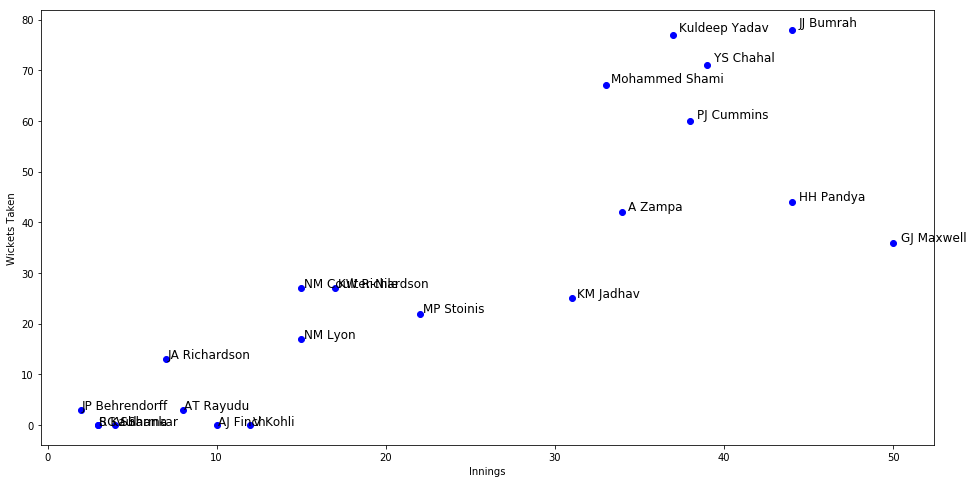

In [331]:
plt.figure(figsize=(16,8))
for i in range(len(agg_group_df)):
    x = agg_group_df.loc[i, 'Total_Inns']
    y = agg_group_df.loc[i, 'Total_Wkts']
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , agg_group_df.loc[i, 'Player'], fontsize=12)
plt.xlabel('Innings')
plt.ylabel('Wickets Taken')
#plt.xlim((0, 100))
#plt.ylim((0, 60))
plt.show()

### Data Preprocessing

In [332]:
def processResult(row):
    if row['Team'] == 'India' and row['Winner'] == 'India':
        return 'WIN'
    elif row['Team'] == 'Australia' and row['Winner'] == 'Australia':
        return 'WIN'
    else:
        return 'LOSS'

In [333]:
df['Result'] = df.apply(processResult, axis=1)

In [334]:
df['Top_Bowler_Rank'] = df.groupby(['Series'])['Wkts'].rank(ascending=False)
df.head(5)

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,...,5,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Bowler_Rank
1,Mohammed Shami,7,7,61.0,7,294,17,17.29,4.81,21.5,...,0,2015-02-15,Australia,ICC Cricket World Cup (in Australia/New Zealan...,India,Misc,AWAY,2015,LOSS,1.0
2,Kuldeep Yadav,6,6,51.0,1,236,17,13.88,4.62,18.0,...,0,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018,WIN,1.0
3,YS Chahal,6,6,52.1,1,262,16,16.37,5.02,19.5,...,1,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018,WIN,2.0
5,JJ Bumrah,5,5,43.2,4,169,15,11.26,3.90,17.3,...,1,2017-08-20,India,"India in Sri Lanka ODI Series, 2017",India,Sri Lanka,AWAY,2017,WIN,1.0
9,Mohammed Shami,3,3,27.4,1,174,10,17.40,6.28,16.6,...,0,2014-10-08,India,"West Indies in India ODI Series, 2014/15",India,West Indies,HOME,2014,WIN,1.0


In [335]:
df.loc[df['Series'] == 'India in New Zealand ODI Series, 2018/19'].sort_values('Top_Bowler_Rank')

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,...,5,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Bowler_Rank
19,YS Chahal,5,5,41.0,0,219,9,24.33,5.34,27.3,...,0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,1.5
20,Mohammed Shami,4,4,29.0,2,138,9,15.33,4.75,19.3,...,0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,1.5
28,Kuldeep Yadav,4,4,29.0,1,125,8,15.62,4.31,21.7,...,0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,3.0
99,HH Pandya,3,3,21.0,1,110,4,27.50,5.23,31.5,...,0,2019-01-28,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,4.0
123,KM Jadhav,5,4,19.0,0,103,3,34.33,5.42,38.0,...,0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,5.0
228,V Shankar,3,3,10.0,0,55,0,NaN,5.50,NaN,...,0,2019-01-23,India,"India in New Zealand ODI Series, 2018/19",India,New Zealand,AWAY,2019,WIN,6.0


In [336]:
encode = {
    
    'Year' : {2014:'2014-2015', 2015:'2014-2015', 2016:'2016-2017', 2017:'2016-2017', 2018:'2018-2019', 
              2019:'2018-2019'}
}

df.replace(encode, inplace=True)

In [337]:
df.head()

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,...,5,Start Date,Winner,Series,Team,Opposition,Venue,Year,Result,Top_Bowler_Rank
1,Mohammed Shami,7,7,61.0,7,294,17,17.29,4.81,21.5,...,0,2015-02-15,Australia,ICC Cricket World Cup (in Australia/New Zealan...,India,Misc,AWAY,2014-2015,LOSS,1.0
2,Kuldeep Yadav,6,6,51.0,1,236,17,13.88,4.62,18.0,...,0,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018-2019,WIN,1.0
3,YS Chahal,6,6,52.1,1,262,16,16.37,5.02,19.5,...,1,2018-02-01,India,"India in South Africa ODI Series, 2017/18",India,South Africa,AWAY,2018-2019,WIN,2.0
5,JJ Bumrah,5,5,43.2,4,169,15,11.26,3.90,17.3,...,1,2017-08-20,India,"India in Sri Lanka ODI Series, 2017",India,Sri Lanka,AWAY,2016-2017,WIN,1.0
9,Mohammed Shami,3,3,27.4,1,174,10,17.40,6.28,16.6,...,0,2014-10-08,India,"West Indies in India ODI Series, 2014/15",India,West Indies,HOME,2014-2015,WIN,1.0


In [338]:
mean_group_df = df.groupby(['Player','Opposition','Venue','Series']).agg({'Inns':'sum','Overs':'sum','Mdns':'sum','Runs':'sum',
                    'Wkts':'sum','Ave':'sum','Econ':'sum','SR':'sum','4':'sum','5':'sum'}).add_prefix('total_').reset_index()
mean_group_df.head()

,Player,Opposition,Venue,Series,total_Inns,total_Overs,total_Mdns,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_5
0,A Zampa,England,HOME,"England in Australia ODI Series, 2017/18",4,36.0,0,215,2,107.50,5.97,108.0,0,0
1,A Zampa,India,AWAY,"Australia in India ODI Series, 2017/18",3,27.0,0,188,4,47.00,6.96,40.5,0,0
2,A Zampa,India,HOME,"India in Australia ODI Series, 2018/19",1,10.0,0,34,0,0.00,3.40,0.0,0,0
3,A Zampa,Ireland,AWAY,Australia v Ireland ODI Match (in South Africa...,1,10.0,1,37,3,12.33,3.70,20.0,0,0
4,A Zampa,Misc,AWAY,"ICC Champions Trophy (in England), 2017",2,12.2,1,65,2,32.50,5.27,37.0,0,0


In [339]:
df = df.merge(mean_group_df, on=['Player','Opposition','Venue','Series'], how='left')

In [340]:
df = df.merge(rating_df, left_on=['Player'], right_on=['Name'], how='left')
df.drop(['Name','Career Best'], axis=1, inplace=True)
df.head()

,Player,Mat,Inns,Overs,Mdns,Runs,Wkts,Ave,Econ,SR,...,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_5,Rank,Rating,Self_Rating_Diff,Rating_Diff
0,Mohammed Shami,7,7,61.0,7,294,17,17.29,4.81,21.5,...,17,17.29,4.81,21.5,1,0,NaN,NaN,NaN,NaN
1,Kuldeep Yadav,6,6,51.0,1,236,17,13.88,4.62,18.0,...,17,13.88,4.62,18.0,2,0,4.0,719.0,46.0,89.0
2,YS Chahal,6,6,52.1,1,262,16,16.37,5.02,19.5,...,16,16.37,5.02,19.5,1,1,5.0,709.0,21.0,99.0
3,JJ Bumrah,5,5,43.2,4,169,15,11.26,3.90,17.3,...,15,11.26,3.90,17.3,1,1,1.0,808.0,33.0,0.0
4,Mohammed Shami,3,3,27.4,1,174,10,17.40,6.28,16.6,...,10,17.40,6.28,16.6,2,0,NaN,NaN,NaN,NaN


In [341]:
df.columns

Index(['Player', 'Mat', 'Inns', 'Overs', 'Mdns', 'Runs', 'Wkts', 'Ave', 'Econ',
       'SR', '4', '5', 'Start Date', 'Winner', 'Series', 'Team', 'Opposition',
       'Venue', 'Year', 'Result', 'Top_Bowler_Rank', 'total_Inns',
       'total_Overs', 'total_Mdns', 'total_Runs', 'total_Wkts', 'total_Ave',
       'total_Econ', 'total_SR', 'total_4', 'total_5', 'Rank', 'Rating',
       'Self_Rating_Diff', 'Rating_Diff'],
      dtype='object')

In [342]:
master_df = df[['Player','Team','Opposition','Venue','Result','total_Inns','total_Overs', 'total_Mdns','total_Runs',
                'total_Wkts','total_Ave','total_Econ','total_SR','total_4','total_5','Rank','Self_Rating_Diff','Rating_Diff',
                'Top_Bowler_Rank']]
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_Overs,total_Mdns,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_5,Rank,Self_Rating_Diff,Rating_Diff,Top_Bowler_Rank
0,Mohammed Shami,India,Misc,AWAY,LOSS,7,61.0,7,294,17,17.29,4.81,21.5,1,0,NaN,NaN,NaN,1.0
1,Kuldeep Yadav,India,South Africa,AWAY,WIN,6,51.0,1,236,17,13.88,4.62,18.0,2,0,4.0,46.0,89.0,1.0
2,YS Chahal,India,South Africa,AWAY,WIN,6,52.1,1,262,16,16.37,5.02,19.5,1,1,5.0,21.0,99.0,2.0
3,JJ Bumrah,India,Sri Lanka,AWAY,WIN,5,43.2,4,169,15,11.26,3.90,17.3,1,1,1.0,33.0,0.0,1.0
4,Mohammed Shami,India,West Indies,HOME,WIN,3,27.4,1,174,10,17.40,6.28,16.6,2,0,NaN,NaN,NaN,1.0


In [343]:
encode = {
    'Player' : {'V Kohli':0,'JJ Bumrah':1,'YS Chahal':2,'S Dhawan':3,'MS Dhoni':4, 'KM Jadhav':5,'S Kaul':6,'Kuldeep Yadav':7,
                'Mohammed Shami':8,'HH Pandya':9,'RR Pant':10,'KL Rahul':11,'AT Rayudu':12,'V Shankar':13,'RG Sharma':14,
                'AJ Finch':15,'JP Behrendorff':16,'AT Carey':17,'NM Coulter-Nile':18,'PJ Cummins':19,'PSP Handscomb':20,
                'UT Khawaja':21,'NM Lyon':22,'SE Marsh':23,'GJ Maxwell':24,'JA Richardson':25,'KW Richardson':26,'MP Stoinis':27,
                'AJ Turner':28,'A Zampa':29},
    
    'Team' : {'India':0, 'Australia':1},
    
    'Opposition' : { 'India':0, 'Australia':1, 'South Africa':2, 'Sri Lanka':3, 'New Zealand':4, 'Pakistan':5, 'West Indies':6,
                     'Scotland':7, 'England':8, 'Ireland':9, 'Bangladesh':10, 'Afghanistan':11, 'Zimbabwe':12, 'Misc':13 },
    
    'Venue': {'HOME':0, 'AWAY':1},
    
    'Result' : {'LOSS':0, 'WIN':1, 'DRAW':2}
}

master_df.replace(encode, inplace=True)

#### Filling in missing values

In [344]:
master_df['Top_Bowler_Rank'] = master_df.groupby(['Player'])['Top_Bowler_Rank'].transform(lambda x: x.fillna(x.mean()))
master_df['Top_Bowler_Rank'] = master_df['Top_Bowler_Rank'].astype('int')

In [345]:
master_df['Rank'].fillna(99,inplace=True)
master_df['Self_Rating_Diff'].fillna(99,inplace=True)
master_df['Rating_Diff'].fillna(999,inplace=True)

#### Target Value Calculation

In [346]:
master_df['Target_Points'] = ((0.10 * master_df['Rank']) + (0.05 * master_df['Self_Rating_Diff']) + (0.05 * master_df['Rating_Diff']) + (0.80 * master_df['Top_Bowler_Rank']))

In [347]:
master_df[['Player','Rank','Self_Rating_Diff','Rating_Diff','Top_Bowler_Rank','Target_Points']].sort_values('Rank')

,Player,Rank,Self_Rating_Diff,Rating_Diff,Top_Bowler_Rank,Target_Points
24,1,1.0,33.0,0.0,1,2.55
53,1,1.0,33.0,0.0,2,3.35
42,1,1.0,33.0,0.0,2,3.35
3,1,1.0,33.0,0.0,1,2.55
37,1,1.0,33.0,0.0,1,2.55
7,1,1.0,33.0,0.0,1,2.55
33,1,1.0,33.0,0.0,6,6.55
30,1,1.0,33.0,0.0,1,2.55
28,1,1.0,33.0,0.0,2,3.35
19,1,1.0,33.0,0.0,1,2.55


In [348]:
master_df.head()

,Player,Team,Opposition,Venue,Result,total_Inns,total_Overs,total_Mdns,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_5,Rank,Self_Rating_Diff,Rating_Diff,Top_Bowler_Rank,Target_Points
0,8,0,13,1,0,7,61.0,7,294,17,17.29,4.81,21.5,1,0,99.0,99.0,999.0,1,65.60
1,7,0,2,1,1,6,51.0,1,236,17,13.88,4.62,18.0,2,0,4.0,46.0,89.0,1,7.95
2,2,0,2,1,1,6,52.1,1,262,16,16.37,5.02,19.5,1,1,5.0,21.0,99.0,2,8.10
3,1,0,3,1,1,5,43.2,4,169,15,11.26,3.90,17.3,1,1,1.0,33.0,0.0,1,2.55
4,8,0,6,0,1,3,27.4,1,174,10,17.40,6.28,16.6,2,0,99.0,99.0,999.0,1,65.60


### Model Evaluation & Feature Selection

In [349]:
predictor_var = ['Opposition','Venue','total_Inns','total_Overs', 'total_Mdns','total_Runs',
                'total_Wkts','total_Ave','total_Econ','total_SR','total_4','total_5','Result']
response_var = ['Target_Points']

In [350]:
X_train, X_test, Y_train, Y_test = train_test_split(master_df[predictor_var], master_df[response_var], test_size=0.2, random_state=0 )

In [351]:
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, Y_train)
xgb_reg.score(X_train, Y_train)

0.9420826954726603

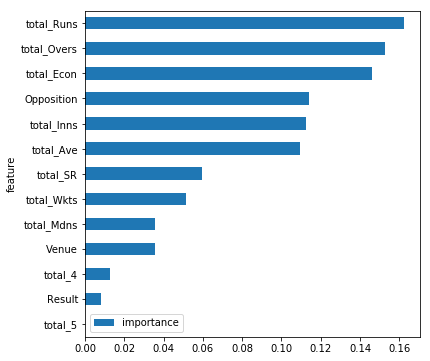

In [352]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = xgb_reg.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(6,6))

### Hyperparameter Tuning

In [353]:
predictor_var = ['Opposition','total_Inns','total_Overs','total_Runs','total_Wkts','total_Ave','total_Econ','total_SR',
                 'total_Mdns','total_4','Result','Venue']
response_var = ['Target_Points']

In [354]:
### Hyperparameter Tuning
param_grid = dict(n_estimators=np.arange(100,600,100), max_depth=np.arange(6,12), learning_rate=(0.0001,0.001,0.01,0.1))
xgb_reg = GridSearchCV(xgb.XGBRegressor(random_state=0), param_grid=param_grid, scoring="r2", n_jobs=-1)
xgb_reg.fit(master_df[predictor_var],master_df[response_var])
print('Best Params:',xgb_reg.best_params_)
print('Best Params:',xgb_reg.best_estimator_)

Best Params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Best Params: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


## Prediction for Highest Wicket Taker in the series

In [355]:
# Test Data Frame
Team = 'India'
Opposition = 'Australia'
Venue = 'HOME'
Result = 'WIN'
Year = '2018-2019'

features = ['Opposition','total_Inns','total_Overs','total_Runs','total_Wkts','total_Ave','total_Econ','total_SR','total_4','total_Mdns']
test_df = mean_group_df.loc[((mean_group_df['Opposition'].isin([Team,Opposition]))
                        )].groupby(['Player','Opposition','Series'])[features].sum().reset_index().loc[:,['Player']+features]
test_df = test_df.groupby(['Player','Opposition'])[features].sum().reset_index().loc[:,['Player']+features]
test_df['Team'] = test_df.apply(lambda x : Opposition if str(x['Opposition'])==Team else Team, axis=1)
test_df['Result'] = test_df.apply(lambda x : 'WIN' if str(x['Team'])==Team else 'LOSS', axis=1)
test_df['Venue'] = test_df.apply(lambda x : 'HOME' if str(x['Team'])==Team else 'AWAY', axis=1)
test_df

,Player,Opposition,total_Inns,total_Overs,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_Mdns,Team,Result,Venue
0,A Zampa,India,4,37.0,222,4,47.00,10.36,40.5,0,0,Australia,LOSS,AWAY
1,AJ Finch,India,2,3.1,18,0,0.00,5.68,0.0,0,0,Australia,LOSS,AWAY
2,AT Rayudu,Australia,1,2.0,13,0,0.00,6.50,0.0,0,0,India,WIN,HOME
3,GJ Maxwell,India,8,27.0,154,1,41.00,13.69,42.0,0,0,Australia,LOSS,AWAY
4,HH Pandya,Australia,5,31.0,188,6,31.33,6.06,31.0,0,0,India,WIN,HOME
5,JA Richardson,India,3,30.0,112,6,18.66,3.73,30.0,1,3,Australia,LOSS,AWAY
6,JJ Bumrah,Australia,5,41.0,202,7,52.40,9.22,67.2,0,3,India,WIN,HOME
7,JP Behrendorff,India,2,18.2,91,3,30.33,4.96,36.6,0,3,Australia,LOSS,AWAY
8,KM Jadhav,Australia,3,23.0,121,2,43.00,10.88,51.0,0,0,India,WIN,HOME
9,KW Richardson,India,6,56.5,335,13,52.07,11.79,52.7,0,2,Australia,LOSS,AWAY


In [356]:
test_df = test_df.merge(rating_df, left_on=['Player'], right_on=['Name'], how='left')
test_df.drop(['Name','Career Best'], axis=1, inplace=True)
test_df.head()

,Player,Opposition,total_Inns,total_Overs,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_4,total_Mdns,Team,Result,Venue,Rank,Rating,Self_Rating_Diff,Rating_Diff
0,A Zampa,India,4,37.0,222,4,47.00,10.36,40.5,0,0,Australia,LOSS,AWAY,68.0,440.0,41.0,368.0
1,AJ Finch,India,2,3.1,18,0,0.00,5.68,0.0,0,0,Australia,LOSS,AWAY,NaN,NaN,NaN,NaN
2,AT Rayudu,Australia,1,2.0,13,0,0.00,6.50,0.0,0,0,India,WIN,HOME,NaN,NaN,NaN,NaN
3,GJ Maxwell,India,8,27.0,154,1,41.00,13.69,42.0,0,0,Australia,LOSS,AWAY,NaN,NaN,NaN,NaN
4,HH Pandya,Australia,5,31.0,188,6,31.33,6.06,31.0,0,0,India,WIN,HOME,53.0,482.0,71.0,326.0


In [357]:
test_df['Rank'].fillna(99,inplace=True)
test_df['Self_Rating_Diff'].fillna(99,inplace=True)
test_df['Rating_Diff'].fillna(999,inplace=True)
test_df.replace(encode, inplace=True)

In [358]:
test_df[predictor_var].head()

,Opposition,total_Inns,total_Overs,total_Runs,total_Wkts,total_Ave,total_Econ,total_SR,total_Mdns,total_4,Result,Venue
0,0,4,37.0,222,4,47.00,10.36,40.5,0,0,0,1
1,0,2,3.1,18,0,0.00,5.68,0.0,0,0,0,1
2,1,1,2.0,13,0,0.00,6.50,0.0,0,0,1,0
3,0,8,27.0,154,1,41.00,13.69,42.0,0,0,0,1
4,1,5,31.0,188,6,31.33,6.06,31.0,0,0,1,0


In [359]:
model = xgb_reg.best_estimator_
model.fit(master_df[predictor_var], master_df[response_var])
Y_pred = model.predict(test_df[predictor_var])

In [360]:
result_df = pd.DataFrame({'Player':test_df['Player'],'Rank_pred':Y_pred}).sort_values('Rank_pred')

player_name=[]
for row in result_df.iterrows():
    player_name.append(list(encode['Player'].items())[int(row[1][0])][0])

result_df['Player']=player_name
result_df.reset_index().drop(['index'],axis=1)

,Player,Rank_pred
0,JJ Bumrah,7.466781
1,YS Chahal,10.546222
2,Kuldeep Yadav,11.268549
3,KW Richardson,12.345991
4,PJ Cummins,16.189421
5,JA Richardson,19.202316
6,NM Lyon,22.099491
7,Mohammed Shami,22.603355
8,NM Coulter-Nile,22.956882
9,HH Pandya,24.853369


### Conclusion

As per the above predictions, **JJ Bumrah** will be the **Highest Wicket Taker** followed by **YS Chahal** & **Kuldeep Yadav** in the upcoming series.